In [1]:
import json
import pandas as pd
import medusa
import cobra
import pickle

from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
# load the open reactions
with open('../results/gimme/mock_gimme_open_reactions_cutoff4.json', 'rb') as infile:
    mock_open_reactions = json.load(infile)
with open('../results/gimme/flg_gimme_open_reactions_cutoff4.json', 'rb') as infile:
    flg_open_reactions = json.load(infile)

In [3]:
mock_fluxes = pd.read_csv('../results/gimme/mock_gimme_tpm_fluxes.tsv',sep='\t')
mock_fluxes = mock_fluxes.drop('Unnamed: 0',axis=1)
flg_fluxes = pd.read_csv('../results/gimme/flg_gimme_tpm_fluxes.tsv',sep='\t')
flg_fluxes = flg_fluxes.drop('Unnamed: 0',axis=1)

flux_vars = list(mock_fluxes.columns)
mock_fluxes.index = ['mock_'+str(label) for label in mock_fluxes.index]
mock_fluxes['class'] = 'mock'
flg_fluxes.index = ['flg_'+str(label) for label in flg_fluxes.index]
flg_fluxes['class'] = 'flg'
all_fluxes = pd.concat([mock_fluxes,flg_fluxes])
all_fluxes

,rxn00020_c,rxn00025_c,rxn00029_c,rxn00048_c,rxn00060_c,rxn00147_c,rxn00148_c,rxn00149_c,rxn00159_c,rxn00161_c,...,rxn05435_c,rxn30674_c,rxn02283_c,rxn02950_c,rxn10226_c,rxn05392_c,rxn09532_c,rxn05220_c,rxn01522_c,class
mock_0,0.0,0.0,0.671169,0.167792,0.167792,0.0,-3.756998,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.288499,2.307996,-0.083896,0.000000,0.0,mock
mock_1,0.0,0.0,0.670189,0.167547,0.167547,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.288078,2.304626,0.000000,0.000000,0.0,mock
mock_2,0.0,0.0,0.690691,0.172673,0.000000,0.0,-7.927228,0.0,0.0,0.0,...,0.000000,188.530191,0.0,0.0,0.296891,2.375128,-0.086336,0.000000,0.0,mock
mock_3,0.0,0.0,0.646350,0.161587,0.161587,0.0,-3.133308,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.277831,2.222650,-0.080794,0.000000,0.0,mock
mock_4,0.0,0.0,0.631134,0.157784,0.157784,0.0,-9.269183,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.271291,2.170326,0.000000,0.000000,0.0,mock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
flg_95,0.0,0.0,0.654935,0.163734,0.163734,0.0,-11.032576,0.0,0.0,0.0,...,2.252170,0.000000,0.0,0.0,0.281521,2.252170,-0.081867,0.000000,0.0,flg
flg_96,0.0,0.0,0.637968,0.159492,0.159492,0.0,0.000000,0.0,0.0,0.0,...,2.193826,0.000000,0.0,0.0,0.274228,2.193826,-0.079746,0.000000,0.0,flg
flg_97,0.0,0.0,0.651056,0.162764,0.162764,0.0,-7.554858,0.0,0.0,0.0,...,2.238832,-48.245451,0.0,0.0,0.279854,2.238832,-0.081382,0.000000,0.0,flg
flg_98,0.0,0.0,0.681219,0.170305,0.170305,0.0,-1.425380,0.0,0.0,0.0,...,2.342556,0.000000,0.0,0.0,0.292819,2.342556,-0.085152,0.000000,0.0,flg


In [4]:
with open('../results/ensembles/psy_ensemble_100_for_analysis.pickle', 'rb') as infile:
    ensemble = pickle.load(infile)

In [5]:
# get the exchange reactions with non-zero flux
all_exchanges = []
for rxn in ensemble.base_model.boundary:
    if rxn.id in all_fluxes.columns:
        all_exchanges.append(rxn.id)

In [6]:
gimme_classifier = RandomForestClassifier(n_estimators = 10000, oob_score = True)

x = all_fluxes.copy()
# include only exchange reactions
x = x[set(all_exchanges)]
y = all_fluxes['class']
feature_names = x.columns

fit_gimme = gimme_classifier.fit(x,y)

In [7]:
from sklearn.metrics import confusion_matrix
y_pred = [a>b for a,b in fit_gimme.oob_decision_function_]
y_true = [a == 'flg' for a in y]
confusion_matrix(y_true, y_pred)

array([[100,   0],
       [  0, 100]])

In [8]:
print(fit_gimme.oob_score_)
# extract feature importances
sorted_importance = pd.DataFrame(fit_gimme.feature_importances_,x.columns, columns = ['importance']).sort_values(by='importance', ascending = False)
top10_imp = sorted_importance.head(20)
ordered_mets = []
for rxn in top10_imp.index:
    rxn_obj = ensemble.base_model.reactions.get_by_id(rxn)
    print(rxn_obj.name)
    ordered_mets.append(rxn_obj.reactants[0].name)
    print(rxn_obj)
    print(rxn_obj.build_reaction_string(use_metabolite_names=True))
    print()

1.0
Exchange reaction for cpd00082_e
EX_cpd00082_e: cpd00082_e <=> 
D-Fructose <=> 

Exchange reaction for cpd00027_e
EX_cpd00027_e: cpd00027_e <=> 
D-Glucose <=> 

Exchange reaction for cpd00130_e
EX_cpd00130_e: cpd00130_e <=> 
L-Malate <=> 

Exchange reaction for cpd00035_e
EX_cpd00035_e: cpd00035_e <=> 
L-Alanine <=> 

Exchange reaction for cpd00164_e
EX_cpd00164_e: cpd00164_e <=> 
Glucuronate <=> 

Exchange reaction for cpd00054_e
EX_cpd00054_e: cpd00054_e <=> 
L-Serine <=> 

Exchange reaction for cpd11585_e
EX_cpd11585_e: cpd11585_e <=> 
L-alanylglycine <=> 

Exchange reaction for cpd00067_e
EX_cpd00067_e: cpd00067_e <=> 
H+ <=> 

Exchange reaction for cpd00117_e
EX_cpd00117_e: cpd00117_e <=> 
D-Alanine <=> 

Exchange reaction for cpd00106_e
EX_cpd00106_e: cpd00106_e <=> 
Fumarate <=> 

Exchange reaction for cpd00132_e
EX_cpd00132_e: cpd00132_e <=> 
L-Asparagine <=> 

Exchange reaction for cpd00001_e
EX_cpd00001_e: cpd00001_e <=> 
H2O <=> 

Exchange reaction for cpd00011_e
EX_cpd0

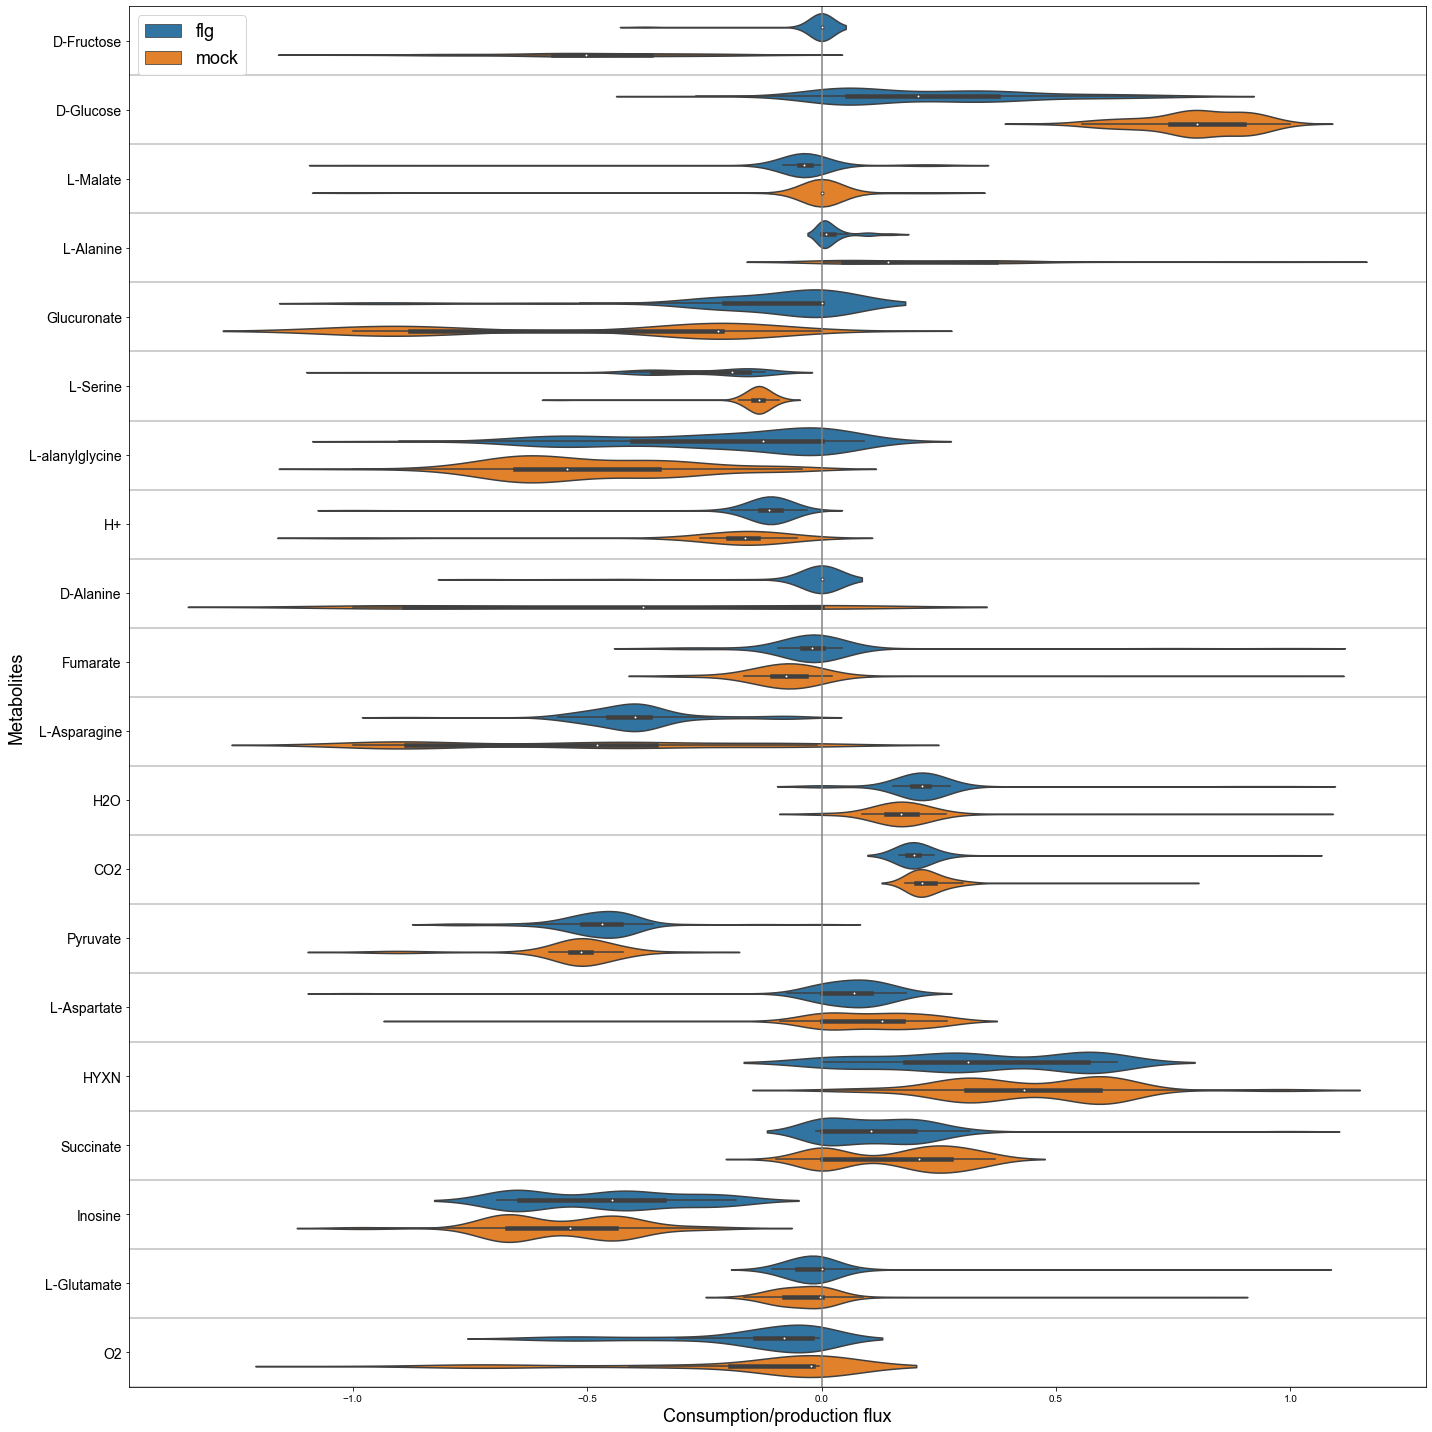

In [9]:
# For the top 10 important features, plot the gimme fluxes
rxns = top10_imp.index
scatter_data = x[top10_imp.index]
# normalize the fluxes by column max
scatter_data = scatter_data.divide(abs(scatter_data).max())

scatter_data['class'] = all_fluxes['class']
scatter_data['sample'] = scatter_data.index
scatter_data = pd.melt(scatter_data,id_vars=['sample','class'],value_vars=rxns, var_name = 'reaction', value_name = 'flux')

f, ax = plt.subplots(figsize=(20,20))
#sns.swarmplot(x='reaction',y='flux',hue='Diagnosis',data=scatter_data,dodge=True)
sns_plot = sns.violinplot(y='reaction',x='flux',hue='class',data=scatter_data.iloc[::-1], order = rxns,orient='h')
sns_plot.set_yticklabels(labels = ordered_mets,size=14)
sns_plot.legend(loc = 'upper left',prop={'size': 18})
sns_plot.axvline(color='grey')
for i in range(0,len(ordered_mets)):
    sns_plot.axhline(i+0.5, color='grey', alpha = 0.5)
sns_plot.set_xlabel('Consumption/production flux',size=18)
sns_plot.set_ylabel('Metabolites',size=18)
plt.tight_layout()
plt.savefig('../results/gimme_top10.svg')
plt.savefig('../results/gimme_top10.png')

In [10]:
# repeat using the internal reactions only
gimme_internal_classifier = RandomForestClassifier(n_estimators = 10000, oob_score = True)

x = all_fluxes.copy()
# Exclude the exchange reactions
x = x[set(flux_vars) - set(all_exchanges)]

y = all_fluxes['class']
feature_names = x.columns

fit_gimme = gimme_internal_classifier.fit(x,y)

In [11]:

# extract feature importances
sorted_importance = pd.DataFrame(fit_gimme.feature_importances_,x.columns, columns = ['importance']).sort_values(by='importance', ascending = False)
top10_imp = sorted_importance.head(40)
ordered_rxns = []
for rxn in top10_imp.index:
    rxn_obj = ensemble.base_model.reactions.get_by_id(rxn)
    print(rxn_obj.name)
    ordered_rxns.append(rxn_obj.name)
    print(rxn_obj)
    print(rxn_obj.build_reaction_string(use_metabolite_names=True))
    print()

Fructose transport via PEP:Pyr PTS (f6p generating) (periplasm)
rxn10175_c: cpd00061_c + cpd00082_e <=> cpd00020_c + cpd00072_c
Phosphoenolpyruvate + D-Fructose <=> Pyruvate + D-fructose-6-phosphate

isovaleryl-coA dehydrogenase
rxn02866_c: cpd00015_c + cpd01882_c --> cpd00982_c + cpd01966_c
FAD + Isovaleryl-CoA --> FADH2 + Dimethylacryloyl-CoA

acyl-CoA dehydrogenase (isovaleryl-CoA)
rxn13659_c: cpd00003_c + cpd01882_c <=> cpd00004_c + cpd00067_c + cpd01966_c
NAD + Isovaleryl-CoA <=> NADH + H+ + Dimethylacryloyl-CoA

D-glucose-6-phosphate aldose-ketose-isomerase
rxn00558_c: cpd00079_c <=> cpd00072_c
D-glucose-6-phosphate <=> D-fructose-6-phosphate

(S)-malate hydro-lyase (fumarate-forming)
rxn00799_c: cpd00130_c <=> cpd00001_c + cpd00106_c
L-Malate <=> H2O + Fumarate

Maltose permease MAL31
rxn05605_c: cpd00067_e + cpd00130_e <=> cpd00067_c + cpd00130_c
H+ + L-Malate <=> H+ + L-Malate

D-glucose transport via PEP:Pyr PTS
rxn05226_c: cpd00027_e + cpd00061_c <=> cpd00020_c + cpd00079_c


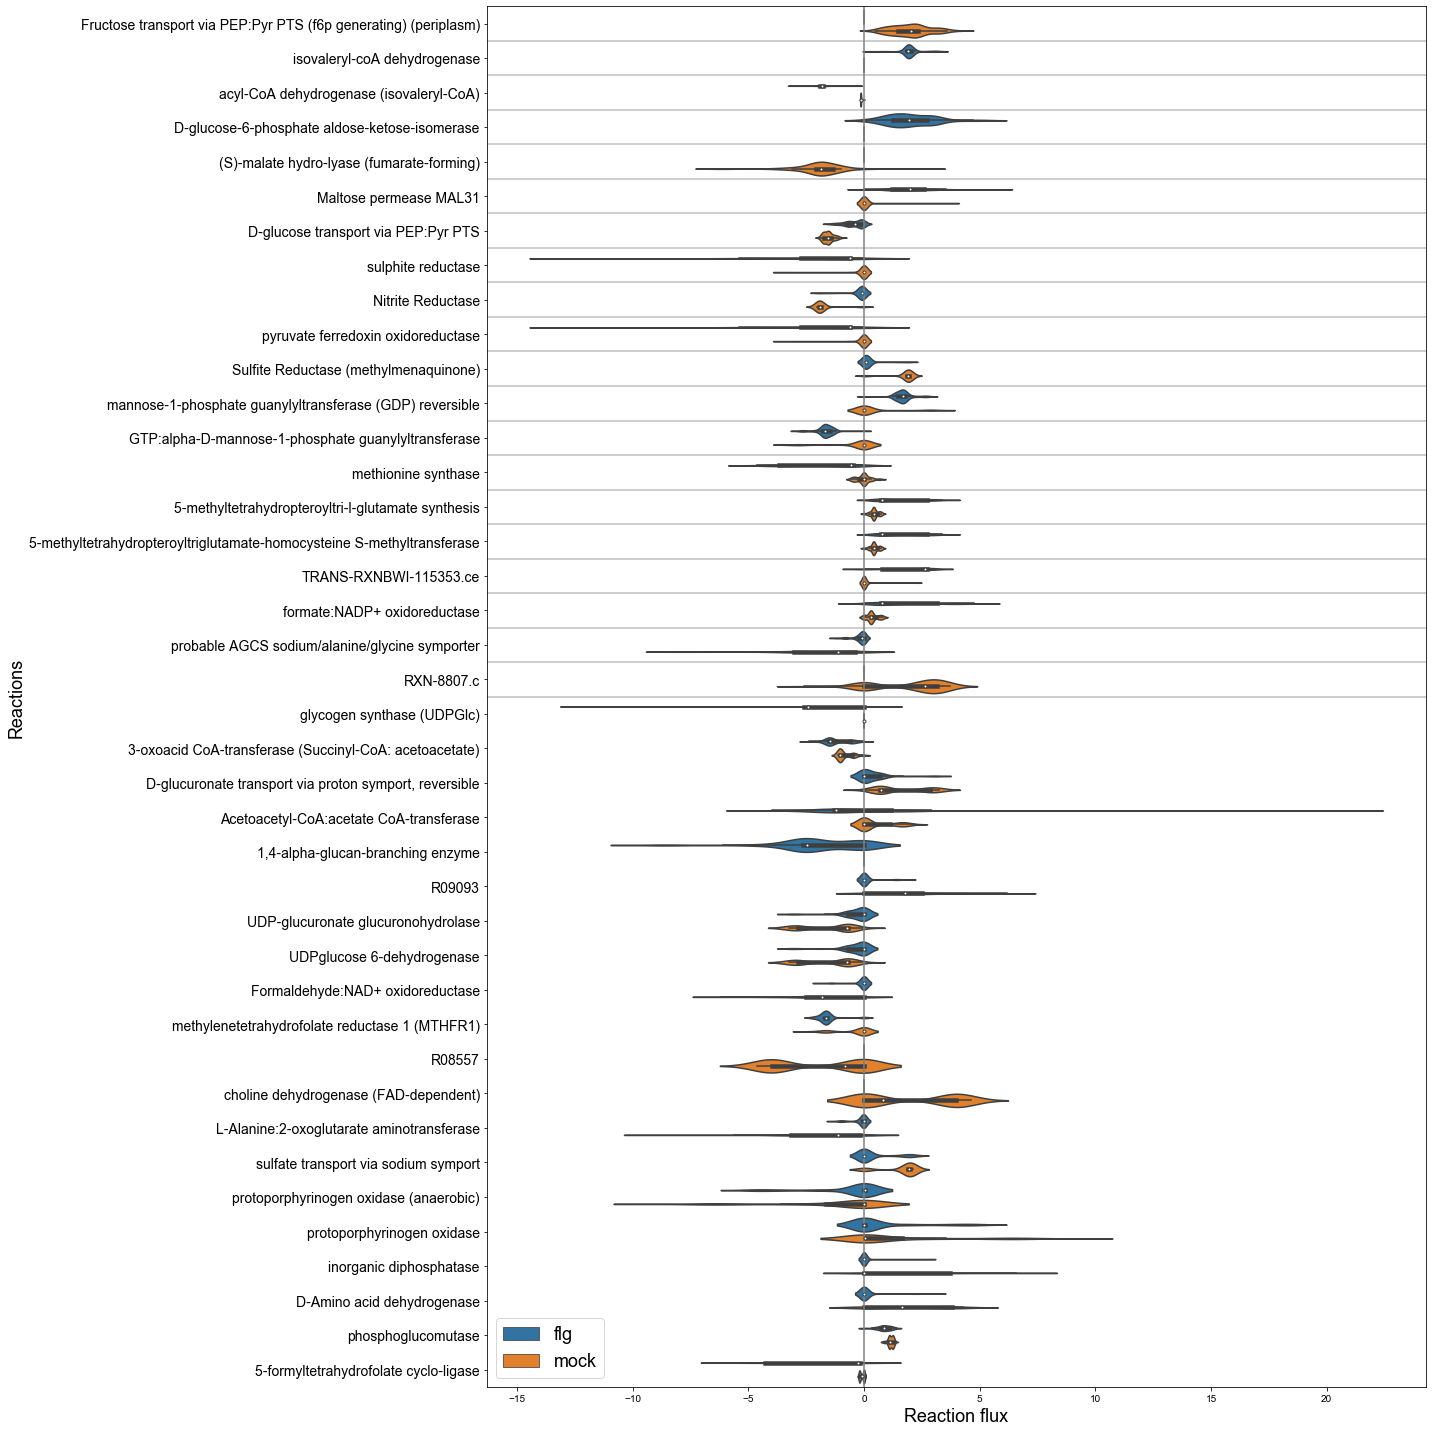

In [12]:
# For the top 10 important features, plot the gimme fluxes
rxns = top10_imp.index
scatter_data = x[top10_imp.index]
# normalize the fluxes by column max
scatter_data = scatter_data.divide(abs(scatter_data).mean())

scatter_data['class'] = all_fluxes['class']
scatter_data['sample'] = scatter_data.index
scatter_data = pd.melt(scatter_data,id_vars=['sample','class'],value_vars=rxns, var_name = 'reaction', value_name = 'flux')

f, ax = plt.subplots(figsize=(20, 20))
#sns.swarmplot(x='reaction',y='flux',hue='Diagnosis',data=scatter_data,dodge=True)
sns_plot = sns.violinplot(y='reaction',x='flux',hue='class',data=scatter_data.iloc[::-1], order = rxns,orient='h')
sns_plot.set_yticklabels(labels = ordered_rxns,size=14, rotation=0, ha='right')
sns_plot.legend(prop={'size': 18})
sns_plot.axvline(color='grey')
for i in range(0,len(ordered_mets)):
    sns_plot.axhline(i+0.5, color='grey', alpha = 0.5)
sns_plot.set_xlabel('Reaction flux',size=18)
sns_plot.set_ylabel('Reactions',size=18)
plt.tight_layout()
plt.savefig('../results/gimme_internal_top10.svg')
plt.savefig('../results/gimme_internal_top10.png')

In [13]:
def open_reaction_frequency(open_reaction_dict):
    open_reactions_freq = {}
    for member in open_reaction_dict.keys():
        for reaction in open_reaction_dict[member]:
            if reaction in open_reactions_freq.keys():
                open_reactions_freq[reaction] += 1
            else:
                open_reactions_freq[reaction] = 1
    return open_reactions_freq

mock_open_compiled = open_reaction_frequency(mock_open_reactions)
flg_open_compiled = open_reaction_frequency(flg_open_reactions)

In [14]:
# convert the open reaction frequency dictionaries into a single dataframe
members_mock = list(mock_open_compiled.keys())
mock_counts_list = [mock_open_compiled[member] for member in mock_open_compiled.keys()]
mock_open_freq_df = pd.DataFrame(mock_counts_list, index = members_mock)
mock_open_freq_df.columns = ['mock']
members_flg = list(flg_open_compiled.keys())
flg_counts_list = [flg_open_compiled[member] for member in flg_open_compiled.keys()]
flg_open_freq_df = pd.DataFrame(flg_counts_list, index = members_flg)
flg_open_freq_df.columns = ['flg']
all_open_freq_df = pd.concat([flg_open_freq_df,mock_open_freq_df], join='outer',sort=True,axis=1).fillna(0)

# get the difference between mock and flg for each
all_open_freq_df['difference from mock'] = all_open_freq_df['mock'] - all_open_freq_df['flg']
# sort by the difference
all_open_freq_df = all_open_freq_df.sort_values(by='difference from mock')

In [15]:
top_only = pd.concat([all_open_freq_df.head(5), all_open_freq_df.tail(5)])
top_only

,flg,mock,difference from mock
rxn02866_c,100.0,0.0,-100.0
rxn00558_c,97.0,0.0,-97.0
rxn05605_c,98.0,1.0,-97.0
EX_cpd00130_e,98.0,7.0,-91.0
rxn05938_c,93.0,5.0,-88.0
rxn10770_c,0.0,68.0,68.0
rxn25164_c,0.0,68.0,68.0
EX_cpd00082_e,10.0,100.0,90.0
rxn00799_c,0.0,97.0,97.0
rxn10175_c,0.0,100.0,100.0


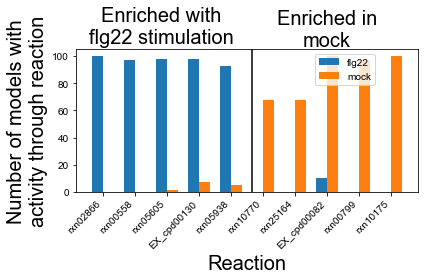

In [16]:
import matplotlib.pyplot as plt
import numpy as np

#temp = top_only.copy()
fig, ax = plt.subplots()
labels = top_only.index.tolist()
labels = [label[:-2] for label in labels] # remove compartment suffix
x = np.arange(len(labels))
width = 0.35

flg_bar = ax.bar(x - width/2, height=top_only['flg'], width = width, label = 'flg22')
mock_bar = ax.bar(x + width/2, height=top_only['mock'], width = width, label = 'mock')

# add a line mid-way through the plotting area to represent the transition from high-flg to high-mock reactions
plt.axvline(x=len(labels)/2 - width, color = 'black')

# Add titles for either side of the plot
ax.set_title('Enriched with\nflg22 stimulation', fontsize=20, loc='center', x = .25)
ax.text(7,107.0,'Enriched in\nmock', size=20,horizontalalignment='center')


ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=45, ha='right')

ax.set_xlabel('Reaction',fontsize=20)
ax.set_ylabel('Number of models with\nactivity through reaction',fontsize=20)
ax.legend(loc=(0.7,0.75))

plt.tight_layout()

fig.savefig('../results/figures/gimme_top_open_reactions.svg')
fig.savefig('../results/figures/gimme_top_open_reactions.png')

In [17]:
ensemble.base_model.reactions.rxn02866_c

Reaction identifier,rxn02866_c
Name,isovaleryl-coA dehydrogenase
Memory address,0x011b8a9940
Stoichiometry,cpd00015_c + cpd01882_c --> cpd00982_c + cpd01966_c FAD + Isovaleryl-CoA --> FADH2 + Dimethylacryloyl-CoA
GPR,PSPTO_2739
Lower bound,0.0
Upper bound,1000.0
